In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import rasterio

def plot_raster(raster_path, label, color_scheme="terrain"):
    """
    Plots a raster with real-world coordinates, a colorbar, and a histogram inset.

    Parameters:
    - raster_path (str): Path to the raster file.
    - label (str): Label of the variable to show on the plot
    - color_scheme (str): Matplotlib colormap (default: "terrain").
    
    Returns:
    - Displays a plot with the raster, colorbar, and histogram.
    """

    # Load raster with rasterio to get georeferencing
    with rasterio.open(raster_path) as src:
        raster = src.read(1)  # Read the first band
        transform = src.transform  # Get the georeferencing transform
        bounds = src.bounds  # Get raster bounding box

    # Handle NoData values
    raster = np.where(raster == src.nodata, np.nan, raster)
    valid_data = raster[~np.isnan(raster)]

    # Compute Color Normalization
    datamin = np.percentile(valid_data, 2)
    datamax = np.percentile(valid_data, 98)
    norm = colors.Normalize(vmin=datamin, vmax=datamax)
    
    # Compute Real-World Extent
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]  # (minX, maxX, minY, maxY)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Display the raster with real-world extent
    img = ax.imshow(raster, cmap=color_scheme, norm=norm, extent=extent, origin="upper")

    ax.set_xlabel("Easting (m)" if src.crs.is_projected else "Longitude (°)")
    ax.set_ylabel("Northing (m)" if src.crs.is_projected else "Latitude (°)")

    # Create a colorbar
    sm = cm.ScalarMappable(cmap=color_scheme, norm=norm)
    sm.set_array([])
    cax = ax.inset_axes([1.05, 0.35, 0.06, 0.5])  # Position the colorbar inset
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('right')

    # Histogram inset
    hax = ax.inset_axes([1.05, 0.05, 0.25, 0.25])
    colormap = plt.colormaps.get_cmap(color_scheme)

    # Filter raster values for histogram
    data = valid_data[(valid_data > datamin) & (valid_data < datamax)]

    # Plot % histogram
    n = len(data)
    _, bins, patches = hax.hist(data, bins=20, edgecolor='none', weights=np.ones(n)/n*100)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Normalize bin centers to [0, 1]
    col = (bin_centers - min(bin_centers)) / (max(bin_centers) - min(bin_centers))

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', colormap(c))

    hax.set_xlabel(label)
    hax.set_ylabel('Occupation (%)')
    hax.yaxis.set_ticks_position('right')
    hax.yaxis.set_label_position('right')

    plt.tight_layout()
    plt.show()


In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from skimage.filters import threshold_otsu

In [10]:
# Function to load raster data
def load_raster(filepath):
    with rasterio.open(filepath) as src:
        data = src.read(1)  # Read first band
        meta = src.meta.copy()
    return data, meta

# Paths to DSM and DTM (Replace with actual file paths)
dsm_path = "data/processed/dsm.tif"
dtm_path = "data/processed/dtm.tif"

# Load DSM and DTM
dsm, meta = load_raster(dsm_path)
dtm, _ = load_raster(dtm_path)

# Compute Canopy Height Model (CHM)
chm = dsm - dtm

with rasterio.open('data/processed/chm.tif', 'w', **meta) as dst:
    dst.write(data.astype(rasterio.float32), 1)


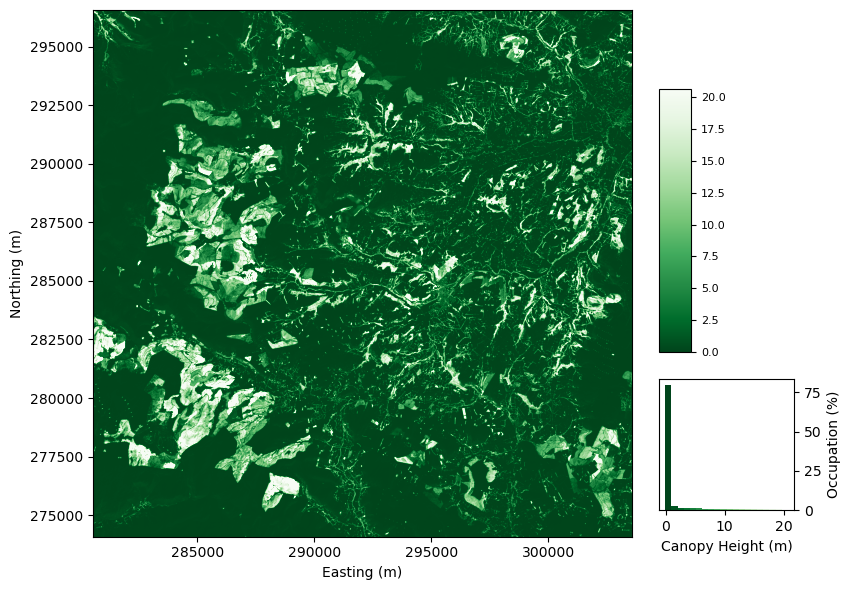

In [12]:
plot_raster('data/processed/chm.tif', label="Canopy Height (m)", color_scheme="Greens_r")

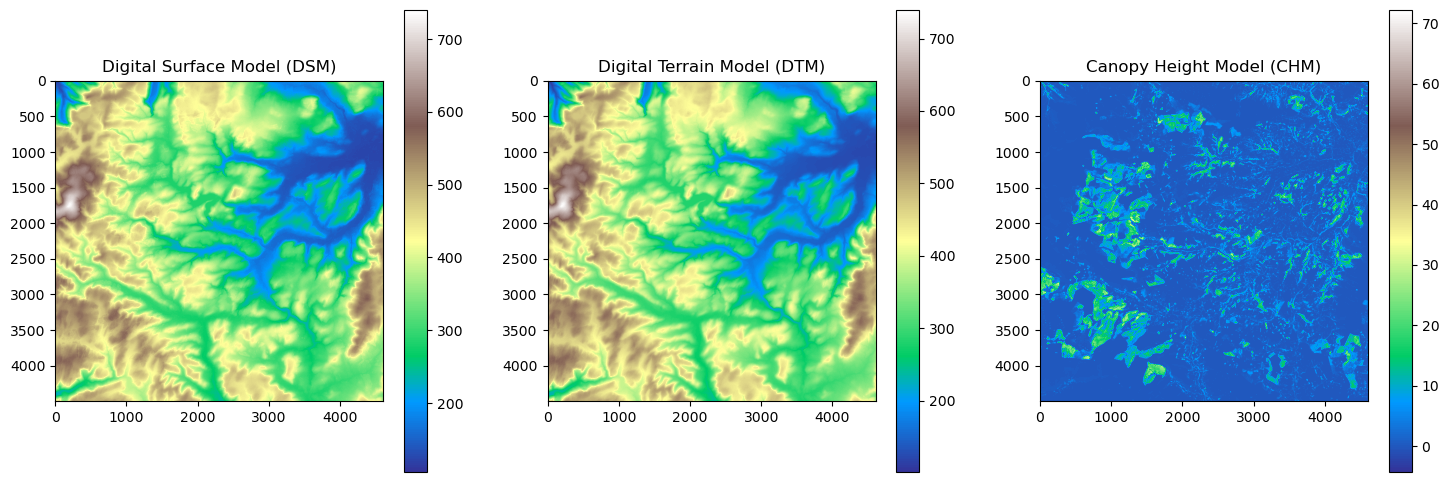

In [4]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax_titles = ["Digital Surface Model (DSM)", "Digital Terrain Model (DTM)", "Canopy Height Model (CHM)"]

data_list = [dsm, dtm, chm]
for ax, data, title in zip(axes, data_list, ax_titles):
    im = ax.imshow(data, cmap='terrain')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
plt.show()

In [5]:
# Compute Canopy Cover using Otsu's thresholding
chm_nonzero = chm[chm > 0]  # Remove non-canopy areas
threshold = threshold_otsu(chm_nonzero)
canopy_cover = (chm > threshold).astype(int)

# Compute percentage cover
canopy_percentage = np.sum(canopy_cover) / np.size(canopy_cover) * 100
print(f"Canopy Cover: {canopy_percentage:.2f}%")


Canopy Cover: 11.85%


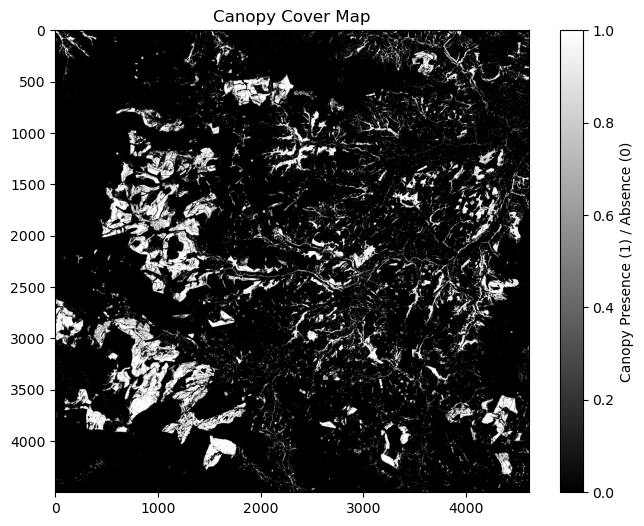

In [6]:
# Visualizing canopy cover
plt.figure(figsize=(8, 6))
plt.imshow(canopy_cover, cmap='gray')
plt.title("Canopy Cover Map")
plt.colorbar(label="Canopy Presence (1) / Absence (0)")
plt.show()

In [7]:
# Extract canopy height statistics
canopy_heights = chm[chm > threshold]
mean_height = np.mean(canopy_heights)
max_height = np.max(canopy_heights)
print(f"Mean Canopy Height: {mean_height:.2f} m")
print(f"Max Canopy Height: {max_height:.2f} m")

Mean Canopy Height: 15.52 m
Max Canopy Height: 72.20 m


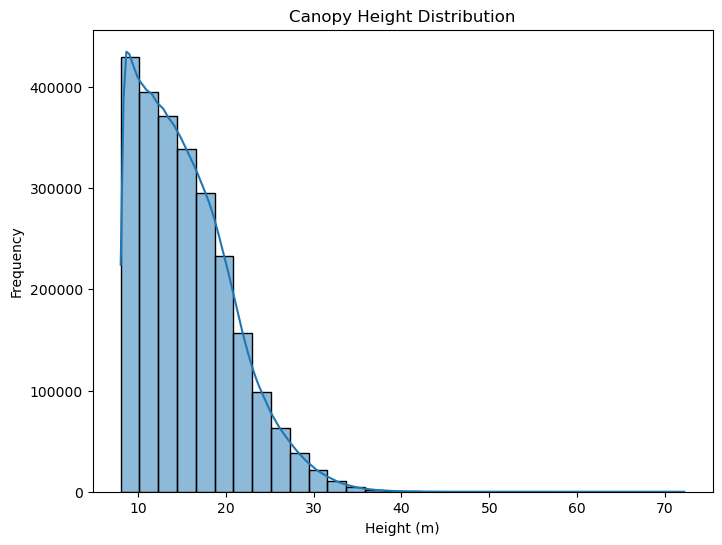

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(canopy_heights, bins=30, kde=True)
plt.title("Canopy Height Distribution")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")
plt.show()